In [17]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

## Metropolis–Hastings algorithm

### Mathematical framework

**Goal:** Sample from a target distribution with density $\pi(x)$ (e.g. a posterior). We cannot sample from $\pi$ directly; we construct a Markov chain whose stationary distribution is $\pi$.

**Notation:**

| Symbol | Meaning |
|--------|--------|
| $x_0$ | Initial position of the chain (chosen by the user or at random). |
| $x_i$ | Current state at step $i$ ($i = 0, 1, 2, \ldots$). |
| $x^*$ | Proposed next state (candidate). |
| $q(x^* \mid x_i)$ | **Proposal distribution:** probability density of proposing $x^*$ given current state $x_i$. |
| $A(x^*, x_i)$ | **Acceptance ratio:** probability with which we accept the move from $x_i$ to $x^*$. |

**One step of the algorithm (from $x_i$ to $x_{i+1}$):**

1. **Propose:** Draw $x^* \sim q(\cdot \mid x_i)$.
2. **Acceptance ratio:**
   $$
   A(x^*, x_i) = \min\left\{ 1,\; \frac{\pi(x^*)\, q(x_i \mid x^*)}{\pi(x_i)\, q(x^* \mid x_i)} \right\}.
   $$
   The ratio $\pi(x^*)/\pi(x_i)$ is the “target ratio”; $q(x_i \mid x^*)/q(x^* \mid x_i)$ corrects for asymmetric proposals (Hastings correction).
3. **Accept/reject:** Draw $u \sim \mathrm{Uniform}(0,1)$. If $u \le A(x^*, x_i)$, set $x_{i+1} = x^*$; otherwise set $x_{i+1} = x_i$.

Under mild conditions, the chain $(x_0, x_1, x_2, \ldots)$ has $\pi$ as its stationary distribution, so after a burn-in period we treat the $x_i$ as approximate samples from $\pi$.

### Implementation: Gaussian random-walk proposal

We use $q(x^* \mid x_i) = \mathcal{N}(x^*; x_i, \sigma^2)$, i.e. $x^* = x_i + \varepsilon$ with $\varepsilon \sim \mathcal{N}(0, \sigma^2)$. The class stores the target $\pi$ and scale $\sigma$, and implements the acceptance ratio $A(x^*, x_i)$ and one-step update above.

In [18]:
class MetroHast():
    """Metropolis–Hastings with Gaussian random-walk proposal $q(x^* \mid x_i) = \mathcal{N}(x^*; x_i, \sigma^2)$.
    Acceptance ratio: $A(x^*, x_i) = \min\bigl(1,\; \pi(x^*) q(x_i \mid x^*) / (\pi(x_i) q(x^* \mid x_i))\bigr)$."""

    def __init__(self, post, sig):
        """Target density (callable) and proposal scale sigma (float)."""
        self.p = post
        self.sig = sig

    @staticmethod
    def PDFgauss(loc, scale, x):
        """Gaussian pdf $\mathcal{N}(x; \mathrm{loc}, \mathrm{scale}^2)$. Inputs: scalars or arrays; output shape matches x."""
        pdf = 1 / np.sqrt(2 * np.pi * scale**2) * np.exp(-(x - loc)**2 / (2 * scale**2))
        return pdf

    def proposal(self, x0):
        """Draw $x^* \sim q(\cdot \mid x_i)$ and return $x^*$, $q(x_i \mid x^*)$, $q(x^* \mid x_i)$. x0: scalar."""
        x1 = np.random.normal(x0, self.sig)
        q_x0_given_x1 = self.PDFgauss(loc=x1, scale=self.sig, x=x0)
        q_x1_given_x0 = self.PDFgauss(loc=x0, scale=self.sig, x=x1)
        return x1, q_x0_given_x1, q_x1_given_x0

    def run(self, N, xinit=0):
        """Run N steps from initial position x_0 = xinit. Returns chain of N states, shape (N,)."""
        samples = []
        x_current = xinit  # shape: scalar
        for i in range(N):
            u = np.random.uniform(0, 1)
            x_star, q_x_current_given_star, q_star_given_x_current = self.proposal(x_current)
            # A(x^*, x_i) = min(1, pi(x^*) q(x_i | x^*) / (pi(x_i) q(x^* | x_i)))
            acceptance_ratio = np.minimum(1.0, self.p(x_star) * q_x_current_given_star / (self.p(x_current) * q_star_given_x_current))
            if u <= acceptance_ratio:
                samples.append(x_star)
                x_current = x_star
            else:
                samples.append(x_current)
            # x_current unchanged on reject
        return np.array(samples)

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/var/folders/7x/df25cbld11n9f4k2nymhtk9m0000gn/T/ipykernel_13089/1555490729.py:2: SyntaxWarning: invalid escape sequence '\m'
  """Metropolis–Hastings with Gaussian random-walk proposal $q(x^* \mid x_i) = \mathcal{N}(x^*; x_i, \sigma^2)$.
/var/folders/7x/df25cbld11n9f4k2nymhtk9m0000gn/T/ipykernel_13089/1555490729.py:12: SyntaxWarning: invalid escape sequence '\m'
  """Gaussian pdf $\mathcal{N}(x; \mathrm{loc}, \mathrm{scale}^2)$. Inputs: scalars or arrays; output shape matches x."""
/var/folders/7x/df25cbld11n9f4k2nymhtk9m0000gn/T/ipykernel_13089/1555490729.py:17: SyntaxWarning: invalid escape sequence '\s'
  """Draw $x^* \sim q(\cdot \mid x_i)$ and return $x^*$, $q(x_i \mid x^*)$, $q(x^

### Target and run

Target $\pi(x) = 0.5\,\mathcal{N}(x; 2, 1) + 0.5\,\mathcal{N}(x; -1, 0.5^2)$. Initial position $x_0 = 0$, proposal scale $\sigma = 0.1$, $N = 10\,000$ steps. Output `res` is the chain of $N$ states, shape $(N,)$.

In [19]:
def posterior(x):
    """Target $\pi(x) = 0.5\,\mathcal{N}(x; 2, 1) + 0.5\,\mathcal{N}(x; -1, 0.5^2)$. Input: array or scalar; output: same shape."""
    loc_1, scale_1 = 2, 1
    loc_2, scale_2 = -1, 0.5
    pdf = 0.5 * (1 / np.sqrt(2 * np.pi * scale_1**2)) * np.exp(-(x - loc_1)**2 / (2 * scale_1**2))
    pdf += 0.5 * (1 / np.sqrt(2 * np.pi * scale_2**2)) * np.exp(-(x - loc_2)**2 / (2 * scale_2**2))
    return pdf

sampler = MetroHast(post=posterior, sig=0.1)
res = sampler.run(10000, xinit=0)  # shape: (10000,) 

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
/var/folders/7x/df25cbld11n9f4k2nymhtk9m0000gn/T/ipykernel_13089/346396084.py:2: SyntaxWarning: invalid escape sequence '\p'
  """Target $\pi(x) = 0.5\,\mathcal{N}(x; 2, 1) + 0.5\,\mathcal{N}(x; -1, 0.5^2)$. Input: array or scalar; output: same shape."""


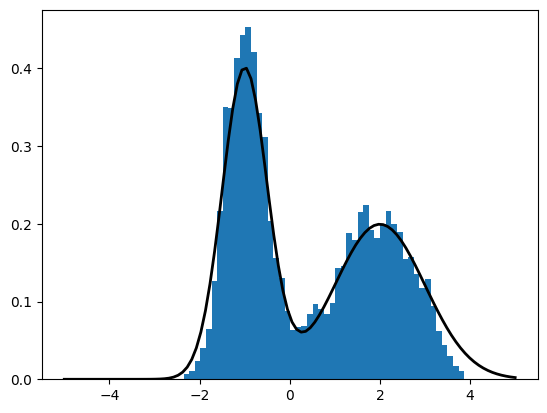

In [20]:
x = np.linspace(-5,5,100)
y = posterior(x)
plt.plot(x,y,color='k',lw=2)
plt.hist(res,bins=50,density=True,histtype='barstacked',color='C0')
plt.show()

### Animation

In [21]:
import matplotlib.animation as animation
from IPython.display import HTML

def run_anim(data, step_size, bins, save_path=None):
    """Animate histogram of data (shape (n_samples,)) in steps of step_size. bins: array or int.
    If save_path is set (e.g. 'mh_anim.html' or 'mh_anim.gif'), the animation is written there and can be opened in a browser or viewer."""
    n = len(data) // step_size
    def update(curr):
        n_samples = min(curr * step_size, len(data))
        plt.cla()
        if n_samples > 0:
            plt.hist(data[:n_samples], bins=bins, density=True, histtype='barstacked', color='C0')
        plt.axis([-5, 5, 0, 0.5])
        plt.gca().set_title('Metropolis–Hastings')
        plt.gca().set_ylabel('frequency')
        plt.gca().set_xlabel('value')
        plt.gca().annotate('n samples = {}'.format(n_samples), xy=(3, 0.3))
        if curr >= n:
            a.event_source.stop()

    fig = plt.figure()
    a = animation.FuncAnimation(fig, update, frames=n + 1, interval=100, repeat=False)
    if save_path:
        if save_path.endswith('.html'):
            with open(save_path, 'w') as f:
                f.write(a.to_jshtml())
            print('Animation saved to', save_path, '(open in a browser to view)')
        else:
            a.save(save_path, writer='pillow')
            print('Animation saved to', save_path)
        plt.close(fig)
        return None
    plt.close(fig)
    return HTML(a.to_jshtml())

bins = np.arange(-5, 5, 0.1)
run_anim(data=res, step_size=50, bins=bins, save_path='/Users/alanzhou/Desktop/Physics/montecarlo-demo/MH.html')

Animation saved to /Users/alanzhou/Desktop/Physics/montecarlo-demo/MH.html (open in a browser to view)
